In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
load = df['T (degC)']
time = df['datetime']

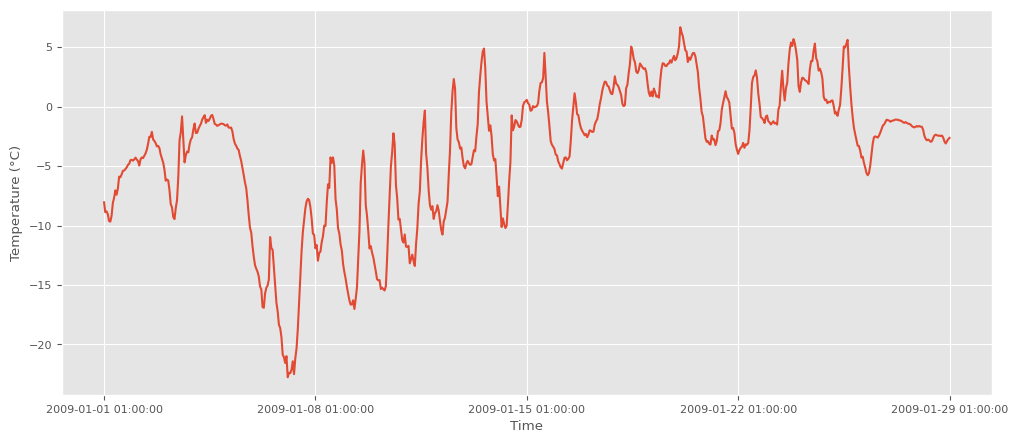

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

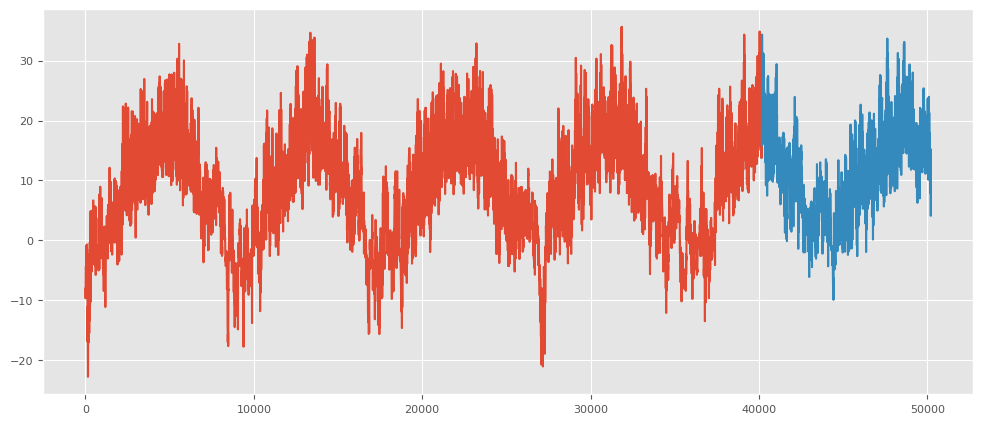

In [6]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

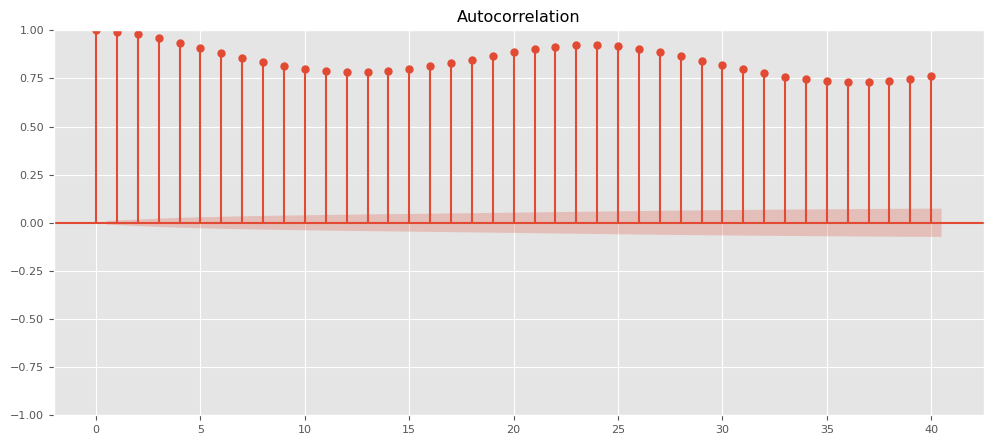

<Figure size 1200x500 with 0 Axes>

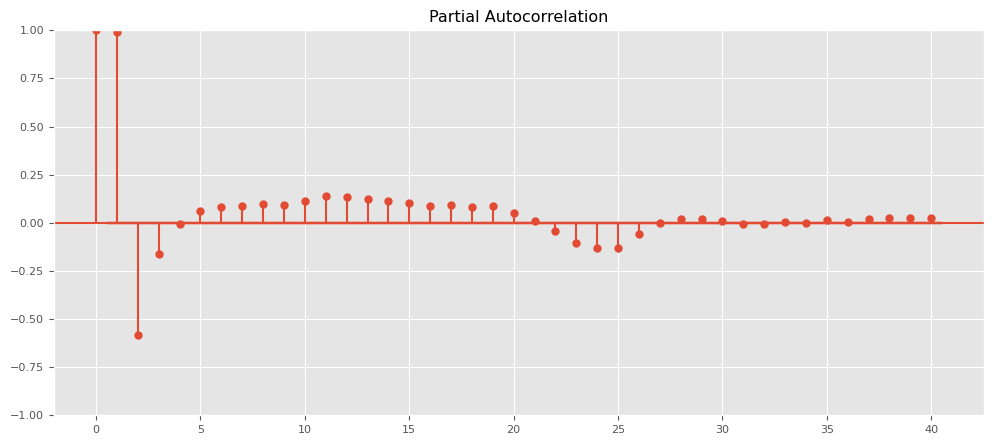

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM¶

In [9]:
!pip install emd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# EEMD

<Axes: xlabel='Time (samples)'>

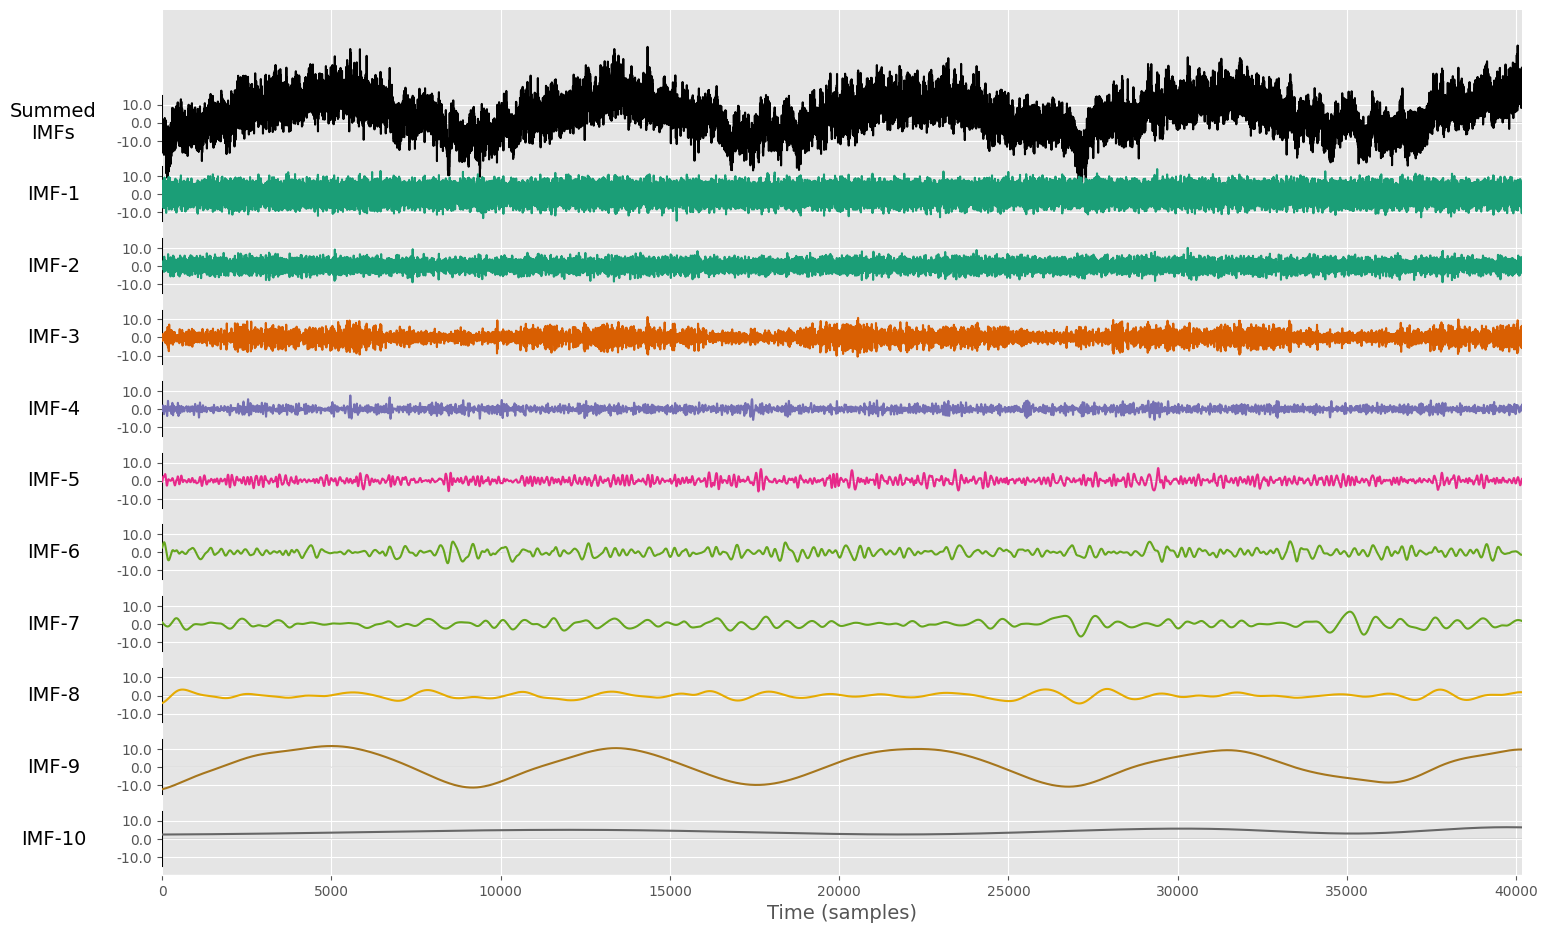

In [10]:
import emd

imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [11]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,6.006700,0.193089,-1.743430,-0.966922,-0.516180,2.676734,0.832033,-4.152738,-12.220927,2.325177
1,3.884696,0.435984,-1.689173,-0.921870,-0.460371,2.744871,0.809576,-4.145165,-12.216398,2.325263
2,-4.996227,1.591299,-1.415774,-0.855817,-0.394841,2.813454,0.787185,-4.137503,-12.211857,2.325350
3,7.498726,2.508199,-0.961020,-0.771184,-0.320438,2.882418,0.764861,-4.129750,-12.207305,2.325437
4,1.901848,2.091345,-0.374505,-0.670569,-0.238057,2.951699,0.742604,-4.121908,-12.202741,2.325524
...,...,...,...,...,...,...,...,...,...,...
40174,1.859123,-0.216486,-2.779237,2.547497,1.135170,-1.298219,1.614644,1.818865,9.743990,6.289502
40175,-6.598144,-0.180940,-4.482528,2.516915,1.145442,-1.288903,1.606316,1.817730,9.743768,6.289150
40176,1.488051,1.407566,-5.584921,2.449577,1.149330,-1.279081,1.597939,1.816573,9.743536,6.288797
40177,-0.649304,3.149923,-5.958151,2.346326,1.147028,-1.268755,1.589513,1.815393,9.743295,6.288443


In [12]:
# imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
# imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

# imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
# imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

# imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
# imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

# imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
# imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

# imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
# imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

# imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
# imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

# imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
# imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

# imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
# imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

In [13]:
from sklearn.preprocessing import MinMaxScaler

def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [15]:
lstm_1 = 64
dropout = 0.2
lstm_2 = 32
dense_1 = 16
dense_2 = 1

epochs = 8
test_length = len(test)

In [16]:
# IMF 1
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

model1 = Sequential()
model1.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dropout(dropout))
model1.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model1.add(Dense(dense_1, activation='relu'))
model1.add(Dense(dense_2))
model1.compile(optimizer='adam', loss='mse')
model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=epochs, verbose=0)
imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# IMF 2
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

model2 = Sequential()
model2.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dropout(dropout))
model2.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model2.add(Dense(dense_1, activation='relu'))
model2.add(Dense(dense_2))
model2.compile(optimizer='adam', loss='mse')
model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=epochs, verbose=0)
imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

model3 = Sequential()
model3.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dropout(dropout))
model3.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model3.add(Dense(dense_1, activation='relu'))
model3.add(Dense(dense_2))
model3.compile(optimizer='adam', loss='mse')
model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=epochs, verbose=0)
imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# IMF 4
imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

model4 = Sequential()
model4.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
model4.add(Dropout(dropout))
model4.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model4.add(Dense(dense_1, activation='relu'))
model4.add(Dense(dense_2))
model4.compile(optimizer='adam', loss='mse')
model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=epochs, verbose=0)
imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# IMF 5
imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

model5 = Sequential()
model5.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
model5.add(Dropout(dropout))
model5.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model5.add(Dense(dense_1, activation='relu'))
model5.add(Dense(dense_2))
model5.compile(optimizer='adam', loss='mse')
model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=0)
imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# IMF 6
imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
imf6_eemd_lstm_X = imf6_eemd_lstm_X.reshape((imf6_eemd_lstm_X.shape[0], 1, imf6_eemd_lstm_X.shape[1]))

model6 = Sequential()
model6.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
model6.add(Dropout(dropout))
model6.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model6.add(Dense(dense_1, activation='relu'))
model6.add(Dense(dense_2))
model6.compile(optimizer='adam', loss='mse')
model6.fit(imf6_eemd_lstm_X, imf6_eemd_lstm_y, epochs=epochs, verbose=0)
imf6_eemd_lstm_fc = model6.predict(imf6_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# IMF 7
imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
imf7_eemd_lstm_X = imf7_eemd_lstm_X.reshape((imf7_eemd_lstm_X.shape[0], 1, imf7_eemd_lstm_X.shape[1]))

model7 = Sequential()
model7.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
model7.add(Dropout(dropout))
model7.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model7.add(Dense(dense_1, activation='relu'))
model7.add(Dense(dense_2))
model7.compile(optimizer='adam', loss='mse')
model7.fit(imf7_eemd_lstm_X, imf7_eemd_lstm_y, epochs=epochs, verbose=0)
imf7_eemd_lstm_fc = model7.predict(imf7_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

# IMF 8
imf8_eemd_lstm_X, imf8_eemd_lstm_y, scaler8 = prepare_data(imf_eemd_df['imf_eemd_8'])
imf8_eemd_lstm_X = imf8_eemd_lstm_X.reshape((imf8_eemd_lstm_X.shape[0], 1, imf8_eemd_lstm_X.shape[1]))

model8 = Sequential()
model8.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf8_eemd_lstm_X.shape[1], imf8_eemd_lstm_X.shape[2])))
model8.add(Dropout(dropout))
model8.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model8.add(Dense(dense_1, activation='relu'))
model8.add(Dense(dense_2))
model8.compile(optimizer='adam', loss='mse')
model8.fit(imf8_eemd_lstm_X, imf8_eemd_lstm_y, epochs=epochs, verbose=0)
imf8_eemd_lstm_fc = model8.predict(imf8_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf8_eemd_lstm_fc = scaler8.inverse_transform(imf8_eemd_lstm_fc)

# IMF 9
imf9_eemd_lstm_X, imf9_eemd_lstm_y, scaler9 = prepare_data(imf_eemd_df['imf_eemd_9'])
imf9_eemd_lstm_X = imf9_eemd_lstm_X.reshape((imf9_eemd_lstm_X.shape[0], 1, imf9_eemd_lstm_X.shape[1]))

model9 = Sequential()
model9.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf9_eemd_lstm_X.shape[1], imf9_eemd_lstm_X.shape[2])))
model9.add(Dropout(dropout))
model9.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model9.add(Dense(dense_1, activation='relu'))
model9.add(Dense(dense_2))
model9.compile(optimizer='adam', loss='mse')
model9.fit(imf9_eemd_lstm_X, imf9_eemd_lstm_y, epochs=epochs, verbose=0)
imf9_eemd_lstm_fc = model9.predict(imf9_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf9_eemd_lstm_fc = scaler9.inverse_transform(imf9_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
# # IMF 9
# imf9_eemd_lstm_X, imf9_eemd_lstm_y, scaler9 = prepare_data(imf_eemd_df['imf_eemd_9'])
# imf9_eemd_lstm_X = imf9_eemd_lstm_X.reshape((imf9_eemd_lstm_X.shape[0], 1, imf9_eemd_lstm_X.shape[1]))

# model9 = Sequential()
# model9.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf9_eemd_lstm_X.shape[1], imf9_eemd_lstm_X.shape[2])))
# model9.add(Dropout(dropout))
# model9.add(LSTM(lstm_2, activation='relu', return_sequences=False))
# model9.add(Dense(dense_1, activation='relu'))
# model9.add(Dense(dense_2))
# model9.compile(optimizer='adam', loss='mse')
# model9.fit(imf9_eemd_lstm_X, imf9_eemd_lstm_y, epochs=epochs, verbose=0)
# imf9_eemd_lstm_fc = model9.predict(imf9_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf9_eemd_lstm_fc = scaler9.inverse_transform(imf9_eemd_lstm_fc)

In [18]:
from statsmodels.tsa.arima.model import ARIMA

imf10_train = imf_eemd_df['imf_eemd_10'].values
imf10_eemd_ARIMA = ARIMA(imf10_train, order=(2, 1, 0))
imf10_eemd_ARIMA_fit = imf10_eemd_ARIMA.fit()
imf10_test = df_test.values
imf10_eemd_ARIMA_fc = imf10_eemd_ARIMA_fit.forecast(steps=len(imf10_test))

# Si quieres predecir los valores de entrenamiento también
# imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.predict(start=0, end=len(imf10_train)-1)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


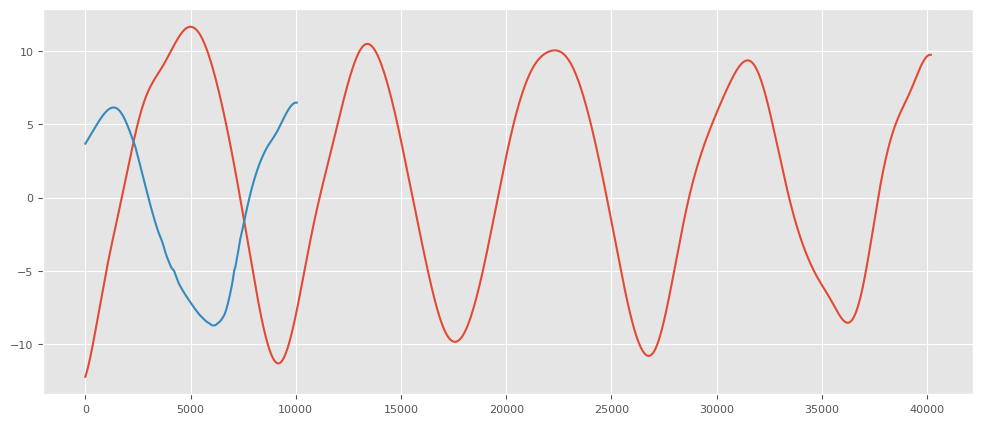

In [19]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_9'])
plt.plot(imf9_eemd_lstm_fc)
plt.show()

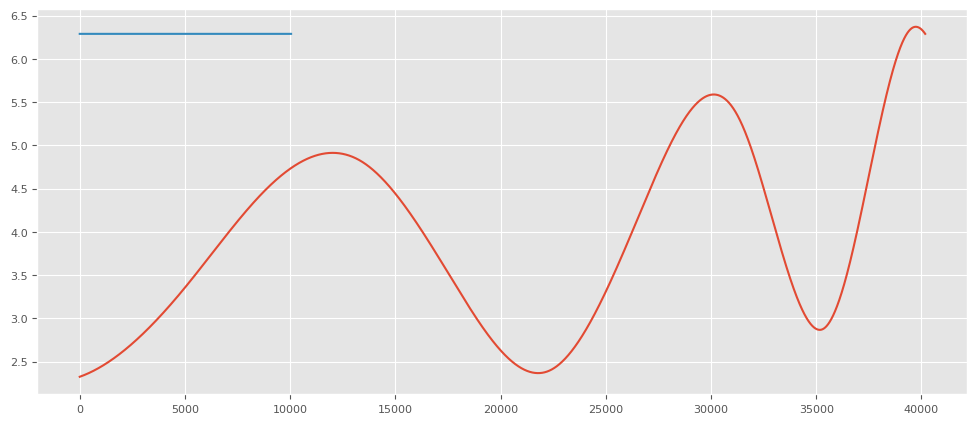

In [20]:
# plot imf10_eemd_SVR_fc real vs predited values
plt.plot(imf_eemd_df['imf_eemd_10'])
plt.plot(imf10_eemd_ARIMA_fc)
plt.show()

In [21]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)
imf8_eemd_lstm_fc_8 = imf8_eemd_lstm_fc.reshape(-1)
imf9_eemd_lstm_fc_9 = imf9_eemd_lstm_fc.reshape(-1)

In [22]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
                imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_lstm_fc_6,
                imf7_eemd_lstm_fc_7, imf8_eemd_lstm_fc_8, imf9_eemd_lstm_fc_9, imf10_eemd_ARIMA_fc], axis = 0)

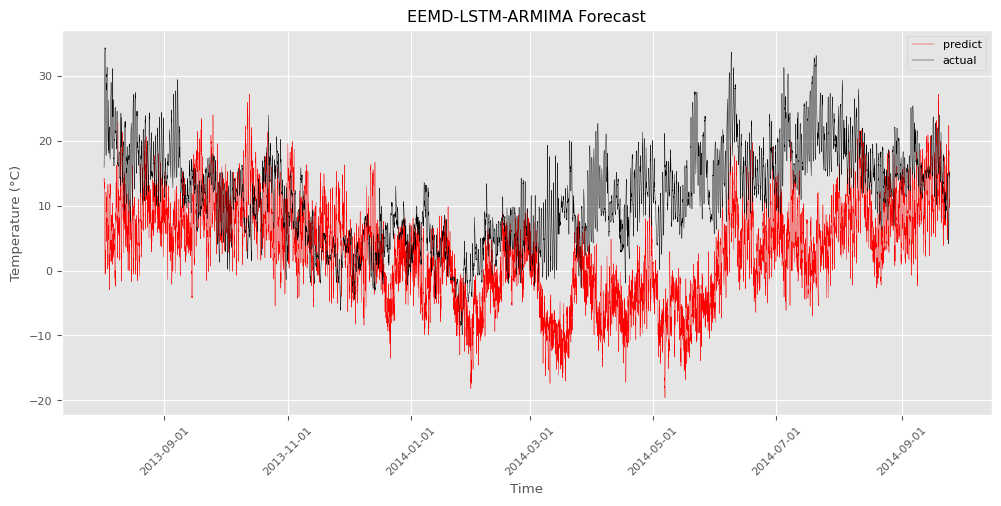

In [23]:
import matplotlib.dates as mdates
import pandas as pd

target_index = 'datetime'
df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-LSTM-ARMIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

In [24]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 153.3383872937506 
MAE = 9.930921614830234 
MAPE = 1562568738264.7512


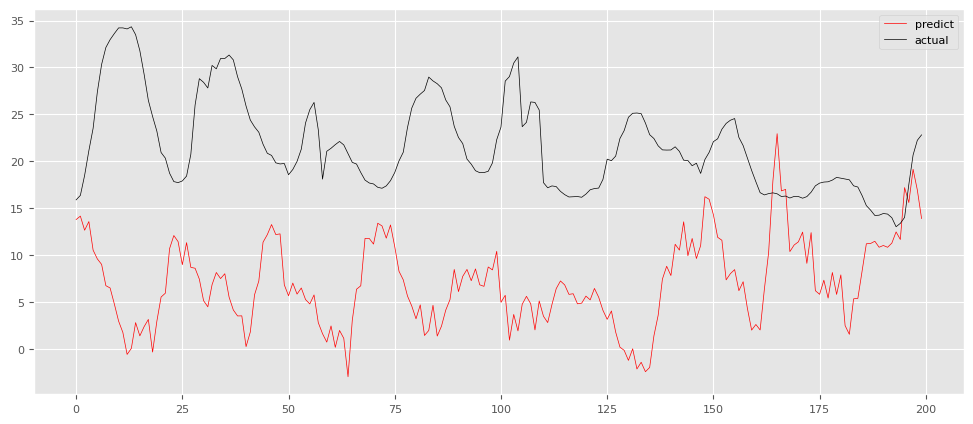

MSE = 153.3383872937506 
MAE = 9.930921614830234 
MAPE = 1562568738264.7512


In [25]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [26]:
# imf1_eemd_SVR_fc_train = imf1_eemd_SVR.predict(np.array(df_train))
# imf2_eemd_SVR_fc_train = imf2_eemd_SVR.predict(np.array(df_train))
# imf3_eemd_SVR_fc_train = imf3_eemd_SVR.predict(np.array(df_train))
# imf4_eemd_SVR_fc_train = imf4_eemd_SVR.predict(np.array(df_train))
# imf5_eemd_SVR_fc_train = imf5_eemd_SVR.predict(np.array(df_train))
# imf6_eemd_SVR_fc_train = imf6_eemd_SVR.predict(np.array(df_train))
# imf7_eemd_SVR_fc_train = imf7_eemd_SVR.predict(np.array(df_train))
# imf8_eemd_SVR_fc_train = imf8_eemd_SVR.predict(np.array(df_train))

In [27]:
# IMF 1
imf1_eemd_lstm_fc_train = model1.predict(imf1_eemd_lstm_X).reshape(-1, 1)
imf1_eemd_lstm_fc_train = scaler1.inverse_transform(imf1_eemd_lstm_fc_train)

# IMF 2
imf2_eemd_lstm_fc_train = model2.predict(imf2_eemd_lstm_X).reshape(-1, 1)
imf2_eemd_lstm_fc_train = scaler2.inverse_transform(imf2_eemd_lstm_fc_train)

# IMF 3
imf3_eemd_lstm_fc_train = model3.predict(imf3_eemd_lstm_X).reshape(-1, 1)
imf3_eemd_lstm_fc_train = scaler3.inverse_transform(imf3_eemd_lstm_fc_train)

# IMF 4
imf4_eemd_lstm_fc_train = model4.predict(imf4_eemd_lstm_X).reshape(-1, 1)
imf4_eemd_lstm_fc_train = scaler4.inverse_transform(imf4_eemd_lstm_fc_train)

# IMF 5
imf5_eemd_lstm_fc_train = model5.predict(imf5_eemd_lstm_X).reshape(-1, 1)
imf5_eemd_lstm_fc_train = scaler5.inverse_transform(imf5_eemd_lstm_fc_train)

# IMF 6
imf6_eemd_lstm_fc_train = model6.predict(imf6_eemd_lstm_X).reshape(-1, 1)
imf6_eemd_lstm_fc_train = scaler6.inverse_transform(imf6_eemd_lstm_fc_train)

# IMF 7
imf7_eemd_lstm_fc_train = model7.predict(imf7_eemd_lstm_X).reshape(-1, 1)
imf7_eemd_lstm_fc_train = scaler7.inverse_transform(imf7_eemd_lstm_fc_train)

# IMF 8
imf8_eemd_lstm_fc_train = model8.predict(imf8_eemd_lstm_X).reshape(-1, 1)
imf8_eemd_lstm_fc_train = scaler8.inverse_transform(imf8_eemd_lstm_fc_train)

# IMF 9
imf9_eemd_lstm_fc_train = model9.predict(imf9_eemd_lstm_X).reshape(-1, 1)
imf9_eemd_lstm_fc_train = scaler9.inverse_transform(imf9_eemd_lstm_fc_train)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step


In [28]:
# imf9_eemd_lstm_fc_train = model9.predict(imf9_eemd_lstm_X).reshape(-1, 1)
# imf9_eemd_lstm_fc_train = scaler9.inverse_transform(imf9_eemd_lstm_fc_train)

In [29]:
imf10_eemd_ARIMA_fc_train = imf10_eemd_ARIMA_fit.forecast(steps=len(np.array(df_train)))

In [ ]:
imf1_eemd_lstm_fc_train = imf1_eemd_lstm_fc_train.reshape(-1)
imf2_eemd_lstm_fc_train = imf2_eemd_lstm_fc_train.reshape(-1)
imf3_eemd_lstm_fc_train = imf3_eemd_lstm_fc_train.reshape(-1)
imf4_eemd_lstm_fc_train = imf4_eemd_lstm_fc_train.reshape(-1)
imf5_eemd_lstm_fc_train = imf5_eemd_lstm_fc_train.reshape(-1)
imf6_eemd_lstm_fc_train = imf6_eemd_lstm_fc_train.reshape(-1)
imf7_eemd_lstm_fc_train = imf7_eemd_lstm_fc_train.reshape(-1)
imf8_eemd_lstm_fc_train = imf8_eemd_lstm_fc_train.reshape(-1)
imf9_eemd_lstm_fc_train = imf9_eemd_lstm_fc_train.reshape(-1)

In [31]:
# imf1_eemd_SVR_fc_train_1 = imf1_eemd_SVR_fc_train[1:]
# imf2_eemd_SVR_fc_train_2 = imf2_eemd_SVR_fc_train[1:]
# imf3_eemd_SVR_fc_train_3 = imf3_eemd_SVR_fc_train[1:]
# imf4_eemd_SVR_fc_train_4 = imf4_eemd_SVR_fc_train[1:]
# imf5_eemd_SVR_fc_train_5 = imf5_eemd_SVR_fc_train[1:]
# imf6_eemd_SVR_fc_train_6 = imf6_eemd_SVR_fc_train[1:]
# imf7_eemd_SVR_fc_train_7 = imf7_eemd_SVR_fc_train[1:]
# imf8_eemd_SVR_fc_train_8 = imf8_eemd_SVR_fc_train[1:]

imf10_eemd_ARIMA_fc_train_10 = imf10_eemd_ARIMA_fc_train[1:]

In [35]:
imf_eemd_fc_train = np.sum([imf1_eemd_lstm_fc_train, imf2_eemd_lstm_fc_train, imf3_eemd_lstm_fc_train,
                imf4_eemd_lstm_fc_train, imf5_eemd_lstm_fc_train, imf6_eemd_lstm_fc_train,
                imf7_eemd_lstm_fc_train, imf8_eemd_lstm_fc_train, imf9_eemd_lstm_fc_train, imf10_eemd_ARIMA_fc_train_10], axis = 0)

In [36]:
train = train[1:]

In [37]:
from scipy.optimize import minimize

def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 10.463112
         Iterations: 43
         Function evaluations: 88
[6.14551089]


In [38]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 90.11270888536126 
MAE = 7.574851220491817 
MAPE = 7073155214265.597


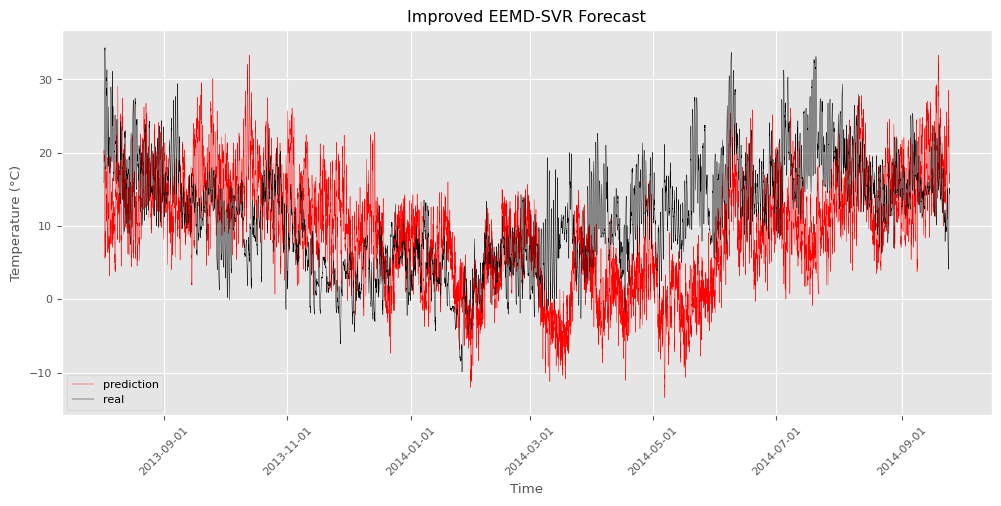

In [39]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-SVR Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

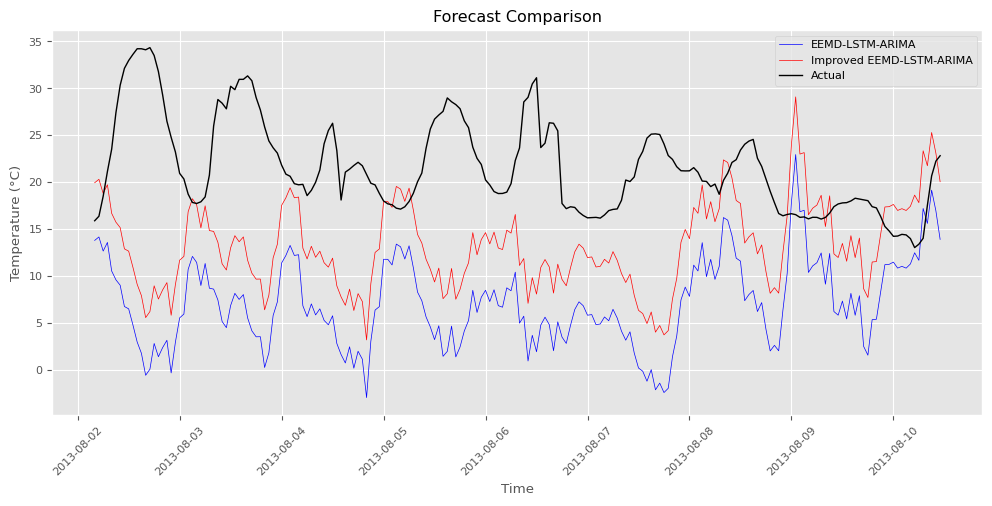

In [40]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-LSTM-ARIMA', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-LSTM-ARIMA', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()